<a href="https://colab.research.google.com/github/kursatkara/MAE_5020_Spring_2025/blob/master/07_01_MINST_Digit_Recognition_FFNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MINST - Digit Recognition - Feed Forward Neural Network

Change the runtime to T4 GPU
On the Menu, go to the Runtime->Change Runtime Type->T4 GPU

## Importing Required Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms


## MNIST Dataset Overview

The **MNIST** (Modified National Institute of Standards and Technology) dataset is a widely used benchmark in machine learning, especially for image classification and neural network training.

### Dataset Characteristics

| Property            | Description                               |
|---------------------|-------------------------------------------|
| **Type**            | Grayscale images of handwritten digits    |
| **Classes**         | 10 digits: 0 through 9                    |
| **Image Size**      | 28 × 28 pixels                            |
| **Color Channels**  | 1 (grayscale)                             |
| **Training Set**    | 60,000 images                             |
| **Test Set**        | 10,000 images                             |
| **Label Format**    | Integer values from 0 to 9                |

---

### Why MNIST?

- Simple but non-trivial — ideal for testing learning algorithms
- Standard benchmark dataset for comparing models
- Pre-loaded in libraries like **PyTorch**, **TensorFlow**, and **Keras**
- Well-documented with many tutorials and research references


## Preparing the MNIST Dataset

We’ll use torchvision’s built-in MNIST dataset. Since our data are images, we convert them to tensors and normalize using the typical mean and standard deviation values for MNIST.

Each MNIST image is 28×28 pixels, which will be flattened to a 784-dimensional input vector for the feed-forward network.

In [2]:
# Define a transform: convert the images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # convert images to Tensor
    transforms.Normalize((0.1307,), (0.3081,))  # normalize using MNIST mean and std
])

# Download and load the training and test datasets
train_dataset = datasets.MNIST(root='/content/sample_data/', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='/content/sample_data/', train=False, download=True, transform=transform)

# DataLoaders for batching and shuffling the dataset
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 15.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 434kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.55MB/s]


Training Data Information:
    Total training samples: 60000
    Sample image shape: torch.Size([1, 28, 28])
    Sample label: 5

Testing Data Information:
    Total testing samples: 10000
    Sample image shape: torch.Size([1, 28, 28])
    Sample label: 7

Training Label Distribution:
    Digit 0: 5923
    Digit 1: 6742
    Digit 2: 5958
    Digit 3: 6131
    Digit 4: 5842
    Digit 5: 5421
    Digit 6: 5918
    Digit 7: 6265
    Digit 8: 5851
    Digit 9: 5949

Testing Label Distribution:
    Digit 0: 980
    Digit 1: 1135
    Digit 2: 1032
    Digit 3: 1010
    Digit 4: 982
    Digit 5: 892
    Digit 6: 958
    Digit 7: 1028
    Digit 8: 974
    Digit 9: 1009


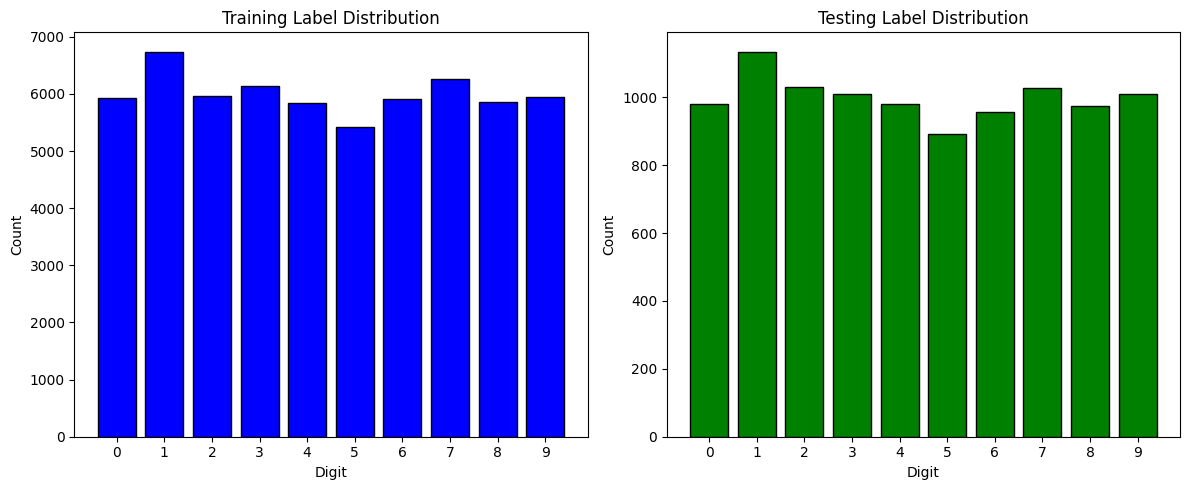

In [3]:
# Print basic information about the datasets
print("Training Data Information:")
print(f"    Total training samples: {len(train_dataset)}")
print(f"    Sample image shape: {train_dataset[0][0].shape}")  # image tensor shape
print(f"    Sample label: {train_dataset[0][1]}")

print("\nTesting Data Information:")
print(f"    Total testing samples: {len(test_dataset)}")
print(f"    Sample image shape: {test_dataset[0][0].shape}")   # image tensor shape
print(f"    Sample label: {test_dataset[0][1]}")

# Get the label tensors (for MNIST the labels are stored in the targets attribute)
train_labels = train_dataset.targets if hasattr(train_dataset, 'targets') else torch.tensor([label for _, label in train_dataset])
test_labels  = test_dataset.targets if hasattr(test_dataset, 'targets') else torch.tensor([label for _, label in test_dataset])

# Convert the label tensors to numpy arrays for ease of use
train_labels_np = train_labels.numpy()
test_labels_np  = test_labels.numpy()

# Calculate the number of occurrences for each class in the training and testing datasets
train_counts = np.bincount(train_labels_np, minlength=10)
test_counts  = np.bincount(test_labels_np,  minlength=10)

print("\nTraining Label Distribution:")
for digit, count in enumerate(train_counts):
    print(f"    Digit {digit}: {count}")

print("\nTesting Label Distribution:")
for digit, count in enumerate(test_counts):
    print(f"    Digit {digit}: {count}")

# Plot the label distributions for both training and testing datasets
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(10), train_counts, color='blue', edgecolor='black')
plt.title('Training Label Distribution')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.xticks(range(10))

plt.subplot(1, 2, 2)
plt.bar(range(10), test_counts, color='green', edgecolor='black')
plt.title('Testing Label Distribution')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.xticks(range(10))

plt.tight_layout()
plt.show()

## Building the Neural Network Model

In this example, we create a simple multilayer perceptron (MLP) with two hidden layers. The network architecture is as follows:

* **Input Layer**: Flattens the 28×28 image into a vector of 784 features.
* **Hidden Layer 1**: Fully connected layer that maps 784 inputs to 512 neurons, followed by a ReLU activation and dropout.
* **Hidden Layer 2**: Fully connected layer mapping 512 inputs to 128 neurons, again with ReLU activation and dropout.
* **Output Layer**: Fully connected layer mapping 128 to 10 outputs (one per digit), with a LogSoftmax activation for numerical stability and compatibility with the negative log likelihood loss (NLLLoss).

In [4]:
# Define your model architecture, which must be exactly the same as during training

class FeedForwardNet(nn.Module):
    def __init__(self):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)  # Helps reduce overfitting

    def forward(self, x):
        # Flatten the image tensor (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(-1, 28 * 28)
        # Pass through first fully connected layer, apply ReLU and dropout
        x = self.dropout(torch.relu(self.fc1(x)))
        # Pass through second fully connected layer, apply ReLU and dropout
        x = self.dropout(torch.relu(self.fc2(x)))
        # Final layer: Apply the LogSoftmax activation
        x = torch.log_softmax(self.fc3(x), dim=1)
        return x

## Configuring the Training

### Device Setup:

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Checking the Pre-Trained Model:

In [6]:
# Create an instance of the model

# Define the model path
model_path = '/content/sample_data/ffnn_mnist_model.pth'

# Check if the model file exists
if os.path.exists(model_path):
    print(f"Pre-trained model found at {model_path}. Loading the model...")

    model = FeedForwardNet().to(device)
    criterion = nn.NLLLoss()            # Suitable for LogSoftmax output
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.load_state_dict(torch.load(model_path))
    pre_trained = True
    print("Model loaded successfully.")
else:
    pre_trained = False
    print(f"Model file not found at {model_path}. Continuing with the newly initialized model.")


Model file not found at /content/sample_data/ffnn_mnist_model.pth. Continuing with the newly initialized model.


### Training the Model

In [7]:
if pre_trained:
    print("Pre-trained model found. Skipping training.")
else:

    model = FeedForwardNet().to(device)
    criterion = nn.NLLLoss()            # Suitable for LogSoftmax output
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    n_epochs = 5  # You can adjust this value as needed

    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        for batch_idx, (data, target) in enumerate(train_loader):
            # Move data and labels to the device (GPU/CPU)
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()         # Zero out gradients to prevent accumulation
            output = model(data)          # Forward pass: compute network output
            loss = criterion(output, target)  # Compute the loss
            loss.backward()               # Backpropagate the loss
            optimizer.step()              # Update the weights

            # Print training status occasionally
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1} [{batch_idx * len(data)}/{len(train_loader.dataset)}]  Loss: {loss.item():.6f}')


Epoch: 1 [0/60000]  Loss: 2.323428
Epoch: 1 [6400/60000]  Loss: 0.547990
Epoch: 1 [12800/60000]  Loss: 0.210147
Epoch: 1 [19200/60000]  Loss: 0.237387
Epoch: 1 [25600/60000]  Loss: 0.275494
Epoch: 1 [32000/60000]  Loss: 0.196365
Epoch: 1 [38400/60000]  Loss: 0.333573
Epoch: 1 [44800/60000]  Loss: 0.179563
Epoch: 1 [51200/60000]  Loss: 0.057668
Epoch: 1 [57600/60000]  Loss: 0.116396
Epoch: 2 [0/60000]  Loss: 0.107520
Epoch: 2 [6400/60000]  Loss: 0.101628
Epoch: 2 [12800/60000]  Loss: 0.164371
Epoch: 2 [19200/60000]  Loss: 0.396718
Epoch: 2 [25600/60000]  Loss: 0.157208
Epoch: 2 [32000/60000]  Loss: 0.161854
Epoch: 2 [38400/60000]  Loss: 0.050585
Epoch: 2 [44800/60000]  Loss: 0.107834
Epoch: 2 [51200/60000]  Loss: 0.155961
Epoch: 2 [57600/60000]  Loss: 0.127020
Epoch: 3 [0/60000]  Loss: 0.199969
Epoch: 3 [6400/60000]  Loss: 0.074683
Epoch: 3 [12800/60000]  Loss: 0.081833
Epoch: 3 [19200/60000]  Loss: 0.019539
Epoch: 3 [25600/60000]  Loss: 0.011535
Epoch: 3 [32000/60000]  Loss: 0.069900
E

## Evaluating the Model

In [8]:
model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
test_loss = 0
correct = 0

with torch.no_grad():  # Disable gradient computations for evaluation
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)        # Get the index of the highest log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = 100. * correct / len(test_loader.dataset)

print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')



Test set: Average loss: 0.0010, Accuracy: 9792/10000 (97.92%)


## Saving the Model

In [9]:
# Save the model's state dictionary to a file
if not pre_trained:
    print("Pre-trained model not found. Saving the model.")
    model_path = '/content/sample_data/ffnn_mnist_model.pth'
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")
else:
    print("Pre-trained model found.")


Pre-trained model not found. Saving the model.
Model saved to /content/sample_data/ffnn_mnist_model.pth


# Visual Results

## Visualizing a Batch of Training Data

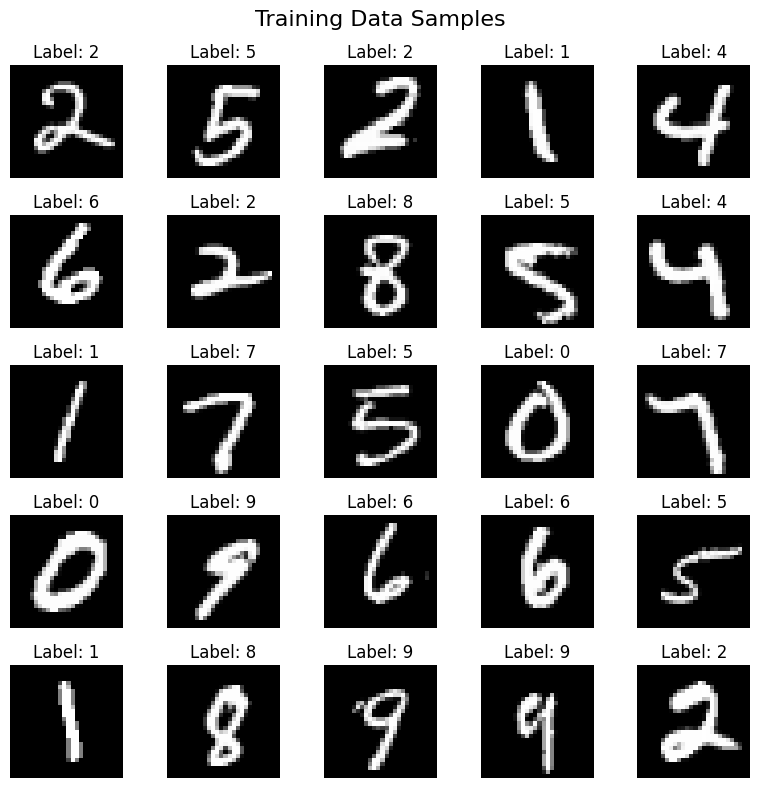

In [10]:
# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid of 25 images (5 x 5)
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
fig.suptitle('Training Data Samples', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        # Unnormalize the image: image * std + mean
        img = images[i] * 0.3081 + 0.1307
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')

plt.tight_layout()
plt.show()


## Visualizing a Batch of Testing Data

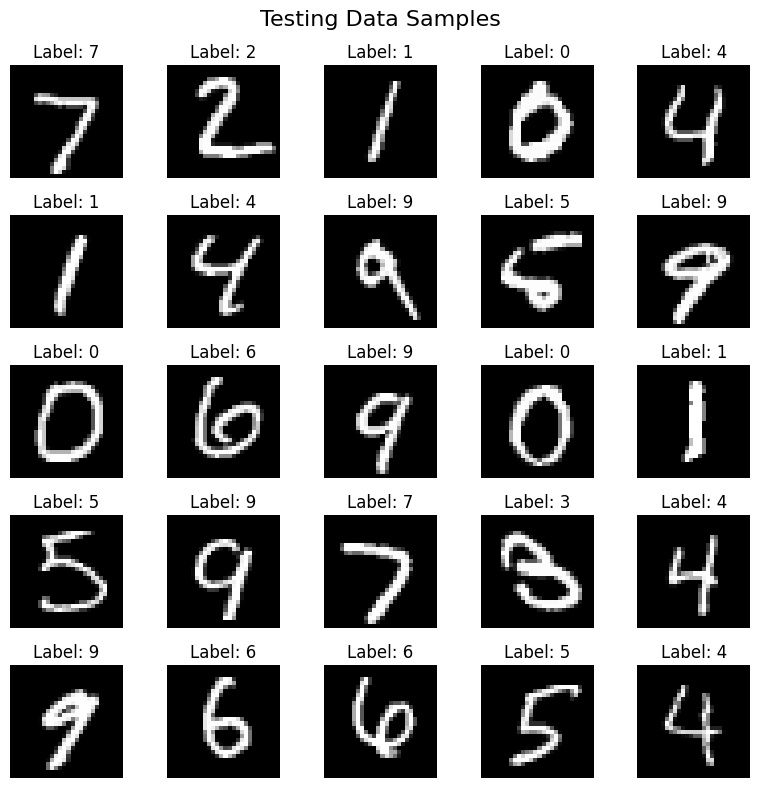

In [11]:
# Get a batch of testing images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Create a grid of 25 images (5 x 5)
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
fig.suptitle('Testing Data Samples', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        # Unnormalize the image: image * std + mean
        img = images[i] * 0.3081 + 0.1307
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')

plt.tight_layout()
plt.show()


## Visualizing Evaluation Results with Prediction Status

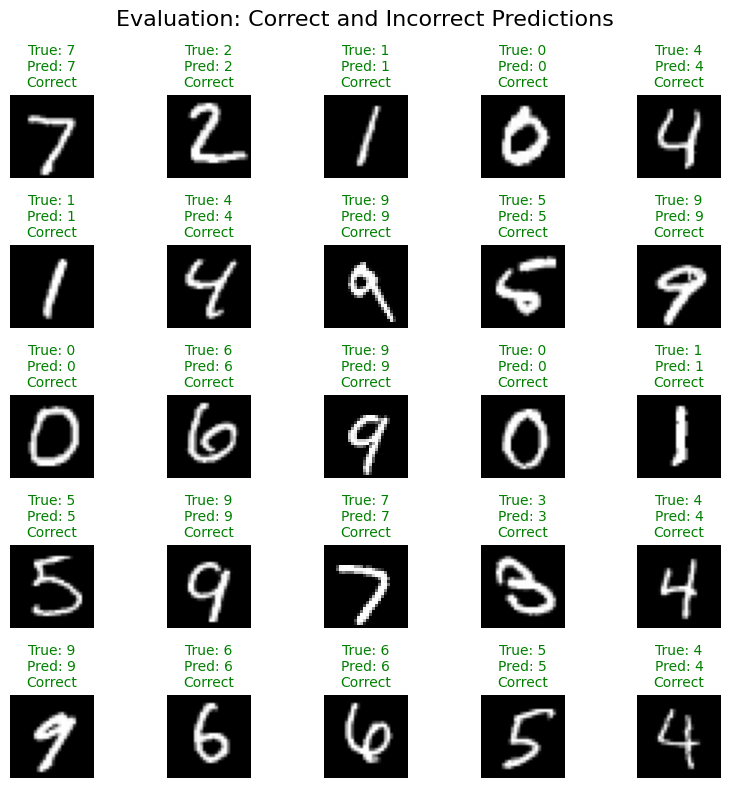

In [12]:
# Ensure the model is in evaluation mode
model.eval()

# Grab a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move data to the appropriate device (if using GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images = images.to(device)
labels = labels.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Bring tensors back to CPU for plotting
images = images.cpu()
labels = labels.cpu()
preds = preds.cpu()

# Create a grid of 25 images (5 x 5) for evaluation results
fig, axes = plt.subplots(5, 5, figsize=(8, 8))
fig.suptitle('Evaluation: Correct and Incorrect Predictions', fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < len(images):
        # Unnormalize the image for visualization
        img = images[i] * 0.3081 + 0.1307
        true_label = labels[i].item()
        pred_label = preds[i].item()
        result = "Correct" if true_label == pred_label else "Incorrect"
        title_color = 'green' if result == "Correct" else 'red'

        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"True: {true_label}\nPred: {pred_label}\n{result}", color=title_color, fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()


## Visualizing Evaluation Results with Failed Predictions

Total number of misclassified images: 208
Showing a random sample of 25 misclassified images.


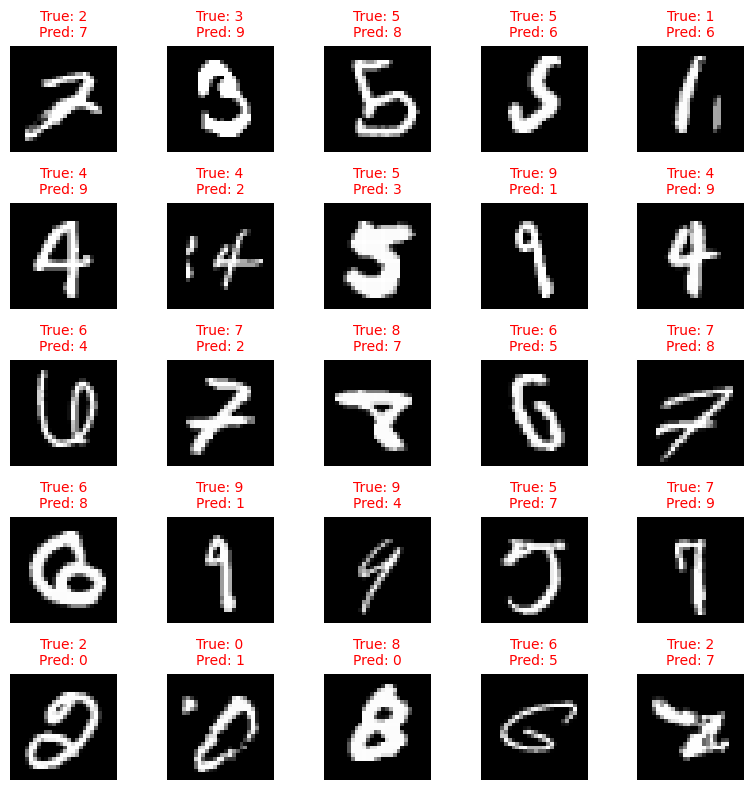

In [13]:
# Set the model to evaluation mode
model.eval()

# Prepare lists to collect misclassified images, their true labels, and predictions
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

# Ensure data is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Iterate through all test batches
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        preds = outputs.argmax(dim=1)
        # Create a boolean mask for misclassified samples
        incorrect_mask = preds != target

        if incorrect_mask.any():
            # Collect misclassified samples from this batch
            misclassified_images.append(data[incorrect_mask].cpu())
            misclassified_true_labels.append(target[incorrect_mask].cpu())
            misclassified_pred_labels.append(preds[incorrect_mask].cpu())

# Combine all batches into single tensors
if misclassified_images:
    misclassified_images = torch.cat(misclassified_images, dim=0)
    misclassified_true_labels = torch.cat(misclassified_true_labels, dim=0)
    misclassified_pred_labels = torch.cat(misclassified_pred_labels, dim=0)

    total_errors = misclassified_images.shape[0]
    print(f"Total number of misclassified images: {total_errors}")

    # If there are many misclassified images, show a random sample (e.g. 25)
    max_images = 25
    if total_errors > max_images:
        indices = torch.randperm(total_errors)[:max_images]
        misclassified_images = misclassified_images[indices]
        misclassified_true_labels = misclassified_true_labels[indices]
        misclassified_pred_labels = misclassified_pred_labels[indices]
        print(f"Showing a random sample of {max_images} misclassified images.")
    else:
        print(f"Showing all {total_errors} misclassified images.")

    # Determine grid size for visualization
    num_images = misclassified_images.shape[0]
    grid_size = int(np.ceil(np.sqrt(num_images)))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    axes = axes.flatten()  # simplify iteration over axes

    for i in range(num_images):
        ax = axes[i]
        # Unnormalize the image to bring it back to displayable format:
        # (MNIST normalization uses mean=0.1307, std=0.3081)
        img = misclassified_images[i] * 0.3081 + 0.1307
        true_label = misclassified_true_labels[i].item()
        pred_label = misclassified_pred_labels[i].item()

        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color='red')
        ax.axis('off')

    # Hide any unused subplots
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images were found in the test dataset.")
